== SHAPE == (1500, 14)


,Timestamp,Suhu Udara (°C),Kelembaban Udara (%),Suhu Tanah (°C),Kelembaban Tanah (%),pH Tanah,Nitrogen (mg/kg),Fosfor (mg/kg),Kalium (mg/kg),Status Kesuburan,Rekomendasi,Curah Hujan (mm),Lokasi,waktu tanam
0,2025-08-27 08:02:41,21.4,50.9,28.4,76.4,4.43,62,187,315,Kurang Subur,"Tambah pupuk sesuai kekurangan (N, P, K) dan p...",1.9,Eucalyptus Farm,120
1,2025-08-27 08:03:09,25.2,52.8,26.5,66.1,7.37,64,24,208,Sedang,Pantau dan sesuaikan pupuk jika perlu,7.8,Eucalyptus Farm,90
2,2025-08-27 08:03:10,21.1,54.1,28.3,70.1,6.54,103,60,224,Sedang,Pantau dan sesuaikan pupuk jika perlu,1.3,Eucalyptus Farm,90
3,2025-08-27 08:03:17,26.2,56.3,30.2,71.5,6.60,102,56,119,Sedang,Pantau dan sesuaikan pupuk jika perlu,0.2,Eucalyptus Farm,90
4,2025-08-27 08:03:22,24.7,48.3,26.4,40.3,7.06,98,59,102,Sedang,Pantau dan sesuaikan pupuk jika perlu,4.7,Eucalyptus Farm,90



== COLUMNS (NORMALIZED) ==
['timestamp', 'suhu_udara_°c', 'kelembaban_udara_%', 'suhu_tanah_°c', 'kelembaban_tanah_%', 'ph_tanah', 'nitrogen_mg_kg', 'fosfor_mg_kg', 'kalium_mg_kg', 'status_kesuburan', 'rekomendasi', 'curah_hujan_mm', 'lokasi', 'waktu_tanam']
FEATURES: ['suhu_udara_°c', 'kelembaban_udara_%', 'suhu_tanah_°c', 'kelembaban_tanah_%', 'ph_tanah', 'nitrogen_mg_kg', 'fosfor_mg_kg', 'kalium_mg_kg', 'curah_hujan_mm']
TARGET: waktu_tanam
Train: (1200, 9), Test: (300, 9)
Training XGBRegressor …
[DAYS-XGB] R2=0.9133 | MAE=4.099 | RMSE=7.470


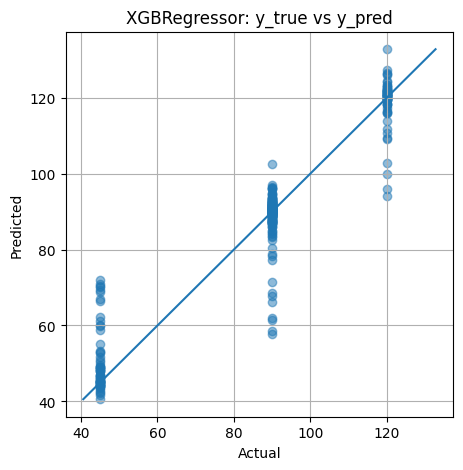

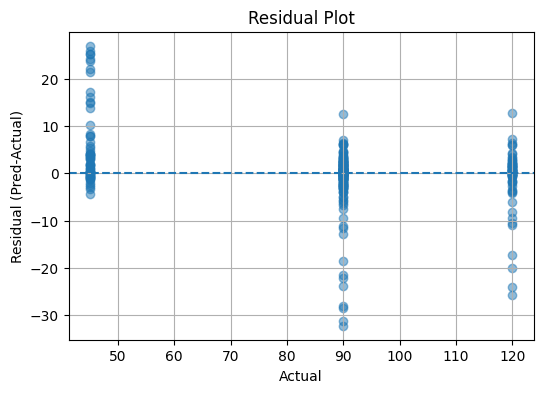

Saved model   : models/waktu_tanam_xgb_reg.pkl
Saved metadata: models/waktu_tanam_metadata.json

Tambahkan ke .env Flask kamu:
USE_DAYS_REGRESSOR=True
MODEL_PATH_DAYS=models/waktu_tanam_xgb_reg.pkl
METADATA_PATH_DAYS=models/waktu_tanam_metadata.json


In [1]:
import os, json, time, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
from pathlib import Path

try:
    from xgboost import XGBRegressor
except Exception as e:
    raise SystemExit("xgboost belum terpasang. Jalankan: !pip install xgboost\n" + str(e))

SEED = 42
np.random.seed(SEED)

def normalize_col(c: str) -> str:
    c = str(c).strip().lower()
    for ch in [" ", "-", ".", ",", "/", "(", ")", "[", "]"]:
        c = c.replace(ch, "_")
    while "__" in c:
        c = c.replace("__", "_")
    return c.strip("_")

def find_col(cols, substrs):
    for c in cols:
        low = c.lower()
        if all(s in low for s in substrs):
            return c
    return None

def compute_rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # sklearn lama
        return math.sqrt(mean_squared_error(y_true, y_pred))

EXCEL_PATH = Path(r"E:\Coding\web-fullstack\ecugrow\notebooks\eucalyptus.xlsx")
SHEET_NAME = None     # nama sheet jika perlu, atau None
TEST_SIZE  = 0.2

MODEL_OUT  = "models/waktu_tanam_xgb_reg.pkl"
META_OUT   = "models/waktu_tanam_metadata.json" 

# Pastikan file ada
assert EXCEL_PATH.exists(), f"File tidak ditemukan: {EXCEL_PATH}"

# === LOAD DATA (mendukung .xlsx/.xls/.csv) ===
suffix = EXCEL_PATH.suffix.lower()
if suffix in (".xlsx", ".xls"):
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME) if SHEET_NAME else pd.read_excel(EXCEL_PATH)
elif suffix == ".csv":
    df = pd.read_csv(EXCEL_PATH)
else:
    raise ValueError(f"Format file tidak dikenali: {suffix}. Gunakan .xlsx/.xls atau .csv")

print("== SHAPE ==", df.shape)
display(df.head())

df.columns = [normalize_col(c) for c in df.columns]
print("\n== COLUMNS (NORMALIZED) ==")
print(list(df.columns))

auto_map = {
    "suhu_udara":       "suhu_udara_°c",
    "kelembapan_udara": "kelembaban_udara_%",
    "suhu_tanah":       "suhu_tanah_°c",
    "kelembapan_tanah": "kelembaban_tanah_%",
    "ph_tanah":         "ph_tanah",
    "nitrogen":         "nitrogen_mg_kg",
    "fosfor":           "fosfor_mg_kg",
    "kalium":           "kalium_mg_kg",
    "curah_hujan":      "curah_hujan_mm",
}

for k, v in list(auto_map.items()):
    if v not in df.columns:
        if k == "kelembapan_udara":
            auto_map[k] = find_col(df.columns, ["kelembab","udara"]) or v
        elif k == "kelembapan_tanah":
            auto_map[k] = find_col(df.columns, ["kelembab","tanah"]) or v
        elif k == "suhu_udara":
            auto_map[k] = find_col(df.columns, ["suhu","udara"]) or v
        elif k == "suhu_tanah":
            auto_map[k] = find_col(df.columns, ["suhu","tanah"]) or v
        elif k == "curah_hujan":
            auto_map[k] = find_col(df.columns, ["curah","hujan"]) or v
        else:
            auto_map[k] = find_col(df.columns, [k.replace("_"," ")]) or v

FEATURES = [auto_map[k] for k in auto_map if auto_map[k] in df.columns]
if not FEATURES:
    raise SystemExit("Tidak ada fitur terdeteksi. Cek nama kolom.")

TARGET = "waktu_tanam_hari" if "waktu_tanam_hari" in df.columns else find_col(df.columns, ["waktu","tanam"])
if not TARGET:
    raise SystemExit("Kolom target waktu tanam tidak ditemukan. Gunakan 'waktu_tanam_hari' atau serupa.")

print("FEATURES:", FEATURES)
print("TARGET:", TARGET)

X = df[FEATURES].apply(pd.to_numeric, errors="coerce")
X = X.mask(X == 0, np.nan)   # ganti 0 → NaN di fitur
y = pd.to_numeric(df[TARGET], errors="coerce")

mask = y.notna()
X, y = X[mask], y[mask]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
print(f"Train: {Xtr.shape}, Test: {Xte.shape}")

pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=SEED,
        n_estimators=900,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        reg_alpha=0.0,
        tree_method="hist",
        n_jobs=-1
    ))
])

print("Training XGBRegressor …")
pipe.fit(Xtr, ytr)
pred = pipe.predict(Xte)

r2  = r2_score(yte, pred)
mae = mean_absolute_error(yte, pred)
try:
    rmse = mean_squared_error(yte, pred, squared=False)
except TypeError:
    rmse = math.sqrt(mean_squared_error(yte, pred))

print(f"[DAYS-XGB] R2={r2:.4f} | MAE={mae:.3f} | RMSE={rmse:.3f}")

# Plot
plt.figure(figsize=(5,5))
plt.scatter(yte, pred, alpha=0.5)
mn, mx = float(np.min([yte.min(), pred.min()])), float(np.max([yte.max(), pred.max()]))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("XGBRegressor: y_true vs y_pred"); plt.grid(True); plt.show()

resid = pred - yte
plt.figure(figsize=(6,4))
plt.scatter(yte, resid, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Actual"); plt.ylabel("Residual (Pred-Actual)")
plt.title("Residual Plot"); plt.grid(True); plt.show()

os.makedirs(os.path.dirname(MODEL_OUT) or ".", exist_ok=True)

joblib.dump(pipe, MODEL_OUT)
meta = {
    "model_kind": "regressor",
    "algo": "xgboost.XGBRegressor",
    "features": FEATURES,
    "target": TARGET,
    "trained_at": int(time.time())
}
with open(META_OUT, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved model   :", MODEL_OUT)
print("Saved metadata:", META_OUT)

print("\nTambahkan ke .env Flask kamu:")
print("USE_DAYS_REGRESSOR=True")
print(f"MODEL_PATH_DAYS={MODEL_OUT}")
print(f"METADATA_PATH_DAYS={META_OUT}")